# Проект: Сервис поиска похожих вопросов для медицинских форумов

## Описание

### Цель

Целью данного проекта является разработка сервиса для поиска похожих вопросов на медицинских форумах. Сервис поможет удержать пользователей на платформе и увеличить количество просмотров страниц, что в свою очередь повысит эффективность рекламных кампаний и улучшит общие показатели форумов.

### Исходные данные

Для обучения и тестирования моделей используется датасет "medical_questions_pairs" от Hugging Face.  Датасет содержит пары вопросов на английском языке, связанных с медицинской тематикой.

### Методы

В проекте будут использованы следующие методы и технологии:

* Обработка естественного языка (NLP) для анализа и предобработки текстовых данных.
* Машинное обучение с использованием различных моделей NLP, таких как Bag-of-Words, TF-IDF, Word2Vec, SentenceTransformers и BERT. 
* FastAPI для создания микросервиса, предоставляющего функциональность поиска похожих вопросов.
* Streamlit для разработки интерактивного веб-приложения для демонстрации работы сервиса.

### Метрики оценки

Качество матчинга вопросов будет оцениваться с использованием следующих метрик: 

* Accuracy@5 - `ключевая метрика`
* Hits@K
* MRR@K (Mean Reciprocal Rank)
* DCG@K (Discounted Cumulative Gain)

## Импорты

In [105]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import spacy
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from skimpy import skim
import time
import chime
from tqdm import tqdm
chime.theme('mario')
%load_ext chime
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from scipy.spatial.distance import pdist, squareform
from pickle import dump

plt.style.use('dark_background')

The chime extension is already loaded. To reload it, use:
  %reload_ext chime


## Загрузка и обзор данных

In [2]:
# Загрузка датасета medical_questions_pairs
try:
    train_df = pd.read_csv('train.csv')

except:
    
    dataset = load_dataset("medical_questions_pairs")

    # Преобразование датасета в pandas DataFrame
    train_df = pd.DataFrame(dataset['train'])
    train_df.to_csv('train.csv',index=False)

# Изучение структуры датасета
print('TRAIN')
print(train_df.info())
print('-------------------')
print()
print('TRAIN')
skim(train_df)
display(train_df.head(3))

TRAIN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3048 entries, 0 to 3047
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   dr_id       3048 non-null   int64 
 1   question_1  3048 non-null   object
 2   question_2  3048 non-null   object
 3   label       3048 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 95.4+ KB
None
-------------------

TRAIN


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 3048   │ │ int32       │ 2     │                                                          │
│ │ Number of columns │ 4      │ │ string      │ 2     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┓  │
│ ┃ column_name         ┃ NA    ┃ NA %     ┃ mean     ┃ sd     ┃ p0    ┃ p25    ┃ p75    ┃ p100    ┃ hist      ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━┩  │
│ │ dr_id               │     0 │        0 │        6 │    3.1 │     1 │      3 │      9 │      11 │  ██▄███   │  │
│ │ label               │     0 │        0 │      0.5 │    0.5 │     0 │      0 │      1 │       1 │  █    █   │  │
│ └─────────────────────┴───────┴──────────┴──────────┴────────┴───────┴────────┴────────┴─────────┴───────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ question_1                │       0 │          0 │                           19 │                    57264 │  │
│ │ question_2                │       0 │          0 │                           19 │                    57264 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

,dr_id,question_1,question_2,label
0,1,After how many hour from drinking an antibioti...,I have a party tonight and I took my last dose...,1
1,1,After how many hour from drinking an antibioti...,I vomited this morning and I am not sure if it...,0
2,1,Am I over weight (192.9) for my age (39)?,I am a 39 y/o male currently weighing about 19...,1


Видно что количество слов одинаково.

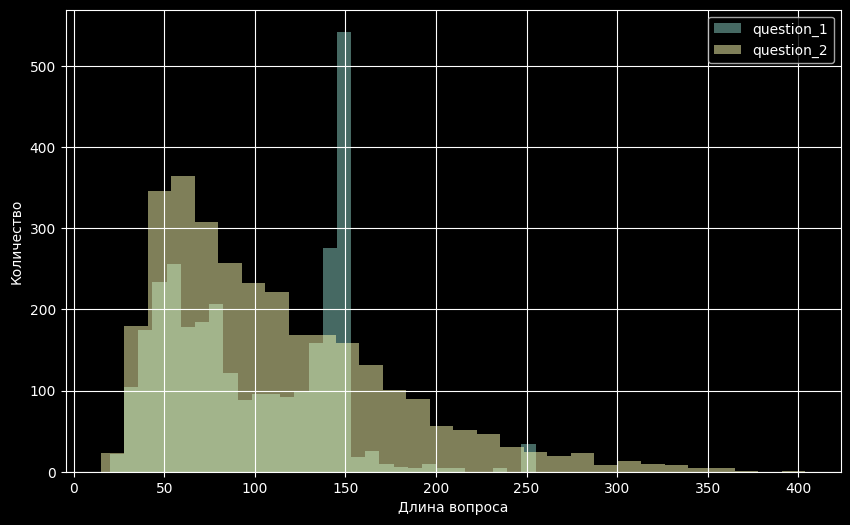

In [3]:
# Анализ длины вопросов
train_df['question_1_length'] = train_df['question_1'].str.len()
train_df['question_2_length'] = train_df['question_2'].str.len()

# Визуализация распределения длины вопросов
plt.figure(figsize=(10, 6))
train_df['question_1_length'].hist(bins=30, alpha=0.5, label='question_1')
train_df['question_2_length'].hist(bins=30, alpha=0.5, label='question_2')
plt.set_cmap('Greens')
plt.xlabel('Длина вопроса')
plt.ylabel('Количество')
plt.legend()
plt.show()

In [102]:
train_df['question_1_length'].describe()

count    3048.000000
mean       99.858924
std        45.640730
min        20.000000
25%        58.000000
50%        94.000000
75%       144.000000
max       255.000000
Name: question_1_length, dtype: float64

In [103]:
train_df['question_2_length'].describe()

count    3048.000000
mean      110.334646
std        63.029785
min        15.000000
25%        62.000000
50%        95.000000
75%       146.000000
max       404.000000
Name: question_2_length, dtype: float64

## Предобработка

In [13]:
nltk.download('punkt')
nltk.download('stopwords')

# Загрузка модели spaCy
nlp = spacy.load("en_core_web_trf")

def preprocess_text(text):
    """
    Функция для предобработки текста.

    Args:
        text (str): Входной текст.

    Returns:
        list: Список обработанных токенов.
    """
    # Токенизация
    tokens = nltk.word_tokenize(text.lower())  # Приведение к нижнему регистру

    # Удаление пунктуации
    tokens = [token for token in tokens if token.isalnum()]

    # Удаление стоп-слов
    stop_words = nltk.corpus.stopwords.words('english')
    tokens = [token for token in tokens if token not in stop_words]

    # Лемматизация
    tokens = [token.lemma_ for token in nlp(" ".join(tokens))]

    # Обработка неизвестных слов (замена на UNK)
    tokens = [token if token != '-PRON-' else 'UNK' for token in tokens]

    return " ".join(tokens)

[nltk_data] Downloading package punkt to C:\Users\elpiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elpiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess_dataframe(df):
    """
    Функция для предобработки DataFrame с вопросами.

    Args:
        df (pd.DataFrame): DataFrame с вопросами.

    Returns:
        pd.DataFrame: DataFrame с предобработанными вопросами.
    """
    df['processed_question_1'] = df['question_1'].apply(preprocess_text)
    df['processed_question_2'] = df['question_2'].apply(preprocess_text)
    return df

In [15]:
%%time
%%chime

try:
    train_df = pd.read_csv('prep_train.csv')
except:
    train_df = preprocess_dataframe(train_df)
    train_df.to_csv('prep_train.csv', index=drop)

In [16]:
chime.success()

In [12]:
# first = train_df.copy()

In [ ]:
1+1

2

## Тестирование моделей

### TF-IDF (НЕУДАЧА)

In [56]:
def get_top_similar_questions(vectorizer, question, question_vectors, n=5):
    """
    Функция для поиска n наиболее похожих вопросов.

    Args:
        question (str): Входной вопрос.
        question_vectors (scipy.sparse.csr_matrix): Матрица векторов TF-IDF.
        n (int, optional): Количество возвращаемых похожих вопросов. Defaults to 5.

    Returns:
        list: Список n наиболее похожих вопросов. 
    """
    # Векторизация входного вопроса
    question_vector = vectorizer.transform([preprocess_text(question)])

    # Вычисление косинусного сходства
    similarity = cosine_similarity(question_vector, question_vectors)[0]

    # Получение индексов наиболее похожих вопросов
    top_indices = np.argsort(similarity)[-n:]

    # Возврат наиболее похожих вопросов
    return train_df.loc[top_indices, 'question_1'].tolist()

def accuracy_at_k(actual, predicted, k=5):
    """
    Вычисляет Accuracy@k.

    Args:
        actual (list): Список истинных меток.
        predicted (list): Список списков предсказанных меток.
        k (int, optional): Значение k. Defaults to 5.

    Returns:
        float: Accuracy@k.
    """
    score = 0.0
    for i in range(len(actual)):
        if actual[i] in predicted[i][:k]:  # Проверяем только первые k элементов
            score += 1.0
    return score / len(actual)

def hits_at_k(actual, predicted, k=5):
    """
    Вычисляет Hits@k.

    Args:
        actual (list): Список истинных меток.
        predicted (list): Список списков предсказанных меток.
        k (int, optional): Значение k. Defaults to 5.

    Returns:
        float: Hits@k.
    """
    score = 0.0
    for i in range(len(actual)):
        if actual[i] in predicted[i][:k]:
            score += 1.0
    return score / len(actual)

def reciprocal_rank(actual, predicted):
    """
    Вычисляет Reciprocal Rank.

    Args:
        actual (list): Список истинных меток.
        predicted (list): Список списков предсказанных меток.

    Returns:
        float: Reciprocal Rank.
    """
    for i, p in enumerate(predicted):
        if actual in p:
            return 1.0 / (i + 1.0)
    return 0.0

def dcg_at_k(actual, predicted, k=5):
    """
    Вычисляет Discounted Cumulative Gain (DCG@k).

    Args:
        actual (list): Список истинных меток.
        predicted (list): Список списков предсказанных меток.
        k (int, optional): Значение k. Defaults to 5.

    Returns:
        float: DCG@k.
    """
    score = 0.0
    for i, p in enumerate(predicted[:k]):
        if p in actual:
            score += 1.0 / np.log2(i + 2)
    return score

def evaluate(df, question_vectors, vectorizer):
    """
    Функция для оценки качества модели.

    Args:
        df (pd.DataFrame): DataFrame с вопросами.
        question_vectors (scipy.sparse.csr_matrix): Матрица векторов TF-IDF.
        vectorizer (TfidfVectorizer): Объект TfidfVectorizer.
    """
    actual = df['question_1'].tolist()
    # predicted = df['question_2'].apply(lambda x: get_top_similar_questions(vectorizer, x, question_vectors, n=5)).tolist()
    predicted = []
    for question in tqdm(df['question_2']):
        predicted.append(get_top_similar_questions(vectorizer, question, question_vectors, n=5))

    print("Accuracy@5:", accuracy_at_k(actual, predicted))
    print("Hits@5:", hits_at_k(actual, predicted))
    print("MRR:", np.mean([reciprocal_rank(a, p) for a, p in zip(actual, predicted)]))
    print("DCG@5:", np.mean([dcg_at_k(a, p) for a, p in zip(actual, predicted)]))

Изменёнка

In [74]:
def get_top_similar_questions_indices(question, question_vectors, vectorizer, n=5):
    """
    Функция для поиска индексов n наиболее похожих вопросов.

    Args:
        question (str): Входной вопрос.
        question_vectors (scipy.sparse.csr_matrix): Матрица векторов TF-IDF.
        vectorizer (TfidfVectorizer): Объект TfidfVectorizer.
        n (int, optional): Количество возвращаемых индексов. Defaults to 5.

    Returns:
        list: Список n индексов наиболее похожих вопросов.
    """

    # Векторизация входного вопроса
    question_vector = vectorizer.transform([preprocess_text(question)])

    # Вычисление косинусного сходства
    similarity = cosine_similarity(question_vector, question_vectors)[0]

    # Получение индексов наиболее похожих вопросов
    top_indices = np.argsort(similarity)[-n:]

    # Возврат индексов наиболее похожих вопросов
    return top_indices.tolist()

def accuracy_at_k(actual, predicted, k=5):
    score = 0.0
    for i in range(len(actual)):
        if i in predicted[i][:k]:  # Проверяем наличие индекса в предсказанных
            score += 1.0
    return score / len(actual)

def hits_at_k(actual, predicted, k=5):
    score = 0.0
    for i in range(len(actual)):
        if i in predicted[i][:k]:
            score += 1.0
    return score / len(actual)

def reciprocal_rank(actual, predicted):
    for i, p in enumerate(predicted):
        if actual in p:
            return 1.0 / (i + 1.0)
    return 0.0

def dcg_at_k(actual, predicted, k=5):
    score = 0.0
    for i, p in enumerate(predicted[:k]):
        if actual in p:
            score += 1.0 / np.log2(i + 2)
    return score

def evaluate(df, question_vectors, vectorizer):
    """
    Функция для оценки качества модели.

    Args:
        df (pd.DataFrame): DataFrame с вопросами.
        question_vectors (scipy.sparse.csr_matrix): Матрица векторов TF-IDF.
        vectorizer (TfidfVectorizer): Объект TfidfVectorizer.
    """
    # actual_labels = df['label'].tolist()
    # predicted = df['question_2'].apply(lambda x: get_top_similar_questions(vectorizer, x, question_vectors, n=5)).tolist()
    actual_labels = [[i] if label == 1 else [] for i, label in enumerate(train_df['label'])]
    predicted = []
    for question in tqdm(df['question_2']):
        predicted.append(get_top_similar_questions_indices(question, question_vectors, vectorizer, n=5))

    print("Примеры predicted:")
    print(predicted[:5])
    print("Примеры actual:")
    print(actual_labels[:5])
    print('------------------------')
    print("Accuracy@5:", accuracy_at_k(actual_labels, predicted))
    print("Hits@5:", hits_at_k(actual_labels, predicted))
    print("MRR:", np.mean([reciprocal_rank(a, p) for a, p in zip(actual_labels, predicted)]))
    print("DCG@5:", np.mean([dcg_at_k(a, p) for a, p in zip(actual_labels, predicted)]))

In [93]:
def get_top_similar_questions_indices(question, question_vectors, vectorizer, n=5):
    """
    Функция для поиска индексов n наиболее похожих вопросов.

    Args:
        question (str): Входной вопрос.
        question_vectors (scipy.sparse.csr_matrix): Матрица векторов TF-IDF.
        vectorizer (TfidfVectorizer): Объект TfidfVectorizer.
        n (int, optional): Количество возвращаемых индексов. Defaults to 5.

    Returns:
        list: Список n индексов наиболее похожих вопросов.
    """

    # Векторизация входного вопроса
    question_vector = vectorizer.transform([preprocess_text(question)])

    # Вычисление косинусного сходства
    similarity = cosine_similarity(question_vector, question_vectors)[0]

    # Получение индексов наиболее похожих вопросов
    top_indices = np.argsort(similarity)[-n:]

    # Возврат индексов наиболее похожих вопросов
    return top_indices.tolist()

def accuracy_at_k(actual, predicted, k=5):
    """
    Вычисляет Accuracy@k.

    Args:
        actual (list): Список списков с индексами релевантных вопросов.
        predicted (list): Список списков с индексами k наиболее похожих вопросов.
        k (int, optional): Значение k. Defaults to 5.

    Returns:
        float: Accuracy@k.
    """
    score = 0.0
    for i in range(len(actual)):
        if any(a in predicted[i][:k] for a in actual[i]):
            score += 1.0
    return score / len(actual)


def hits_at_k(actual, predicted, k=5):
    """
    Вычисляет Hits@k.

    Args:
        actual (list): Список списков с индексами релевантных вопросов.
        predicted (list): Список списков с индексами k наиболее похожих вопросов.
        k (int, optional): Значение k. Defaults to 5.

    Returns:
        float: Hits@k.
    """
    score = 0.0
    for i in range(len(actual)):
        if set(actual[i]).intersection(predicted[i][:k]):
            score += 1.0
    return score / len(actual)


def reciprocal_rank(actual, predicted):
    """
    Вычисляет Reciprocal Rank.

    Args:
        actual (list): Список с индексом релевантного вопроса.
        predicted (list): Список с индексами похожих вопросов.

    Returns:
        float: Reciprocal Rank.
    """
    if actual:  # Проверяем, не пустой ли список actual
        for i, p in enumerate(predicted):
            if actual[0] == p:
                return 1.0 / (i + 1.0)
    return 0.0

def dcg_at_k(actual, predicted, k=5):
    """
    Вычисляет Discounted Cumulative Gain (DCG@k).

    Args:
        actual (list): Список с индексом релевантного вопроса.
        predicted (list): Список с индексами похожих вопросов.
        k (int, optional): Значение k. Defaults to 5.

    Returns:
        float: DCG@k.
    """
    score = 0.0
    if actual:
        for i, p in enumerate(predicted[:k]):
            if p == actual[0]:
                score += 1.0 / np.log2(i + 2)
    return score


def evaluate(df, question_vectors, vectorizer):
    """
    Функция для оценки качества модели.

    Args:
        df (pd.DataFrame): DataFrame с вопросами и метками.
        question_vectors (scipy.sparse.csr_matrix): Матрица векторов TF-IDF.
        vectorizer (TfidfVectorizer): Объект TfidfVectorizer.
    """
    actual_labels = [[i] if label == 1 else [] for i, label in enumerate(df['label'])]
    predicted = []
    for question in tqdm(df['question_2']):
        predicted.append(get_top_similar_questions_indices(question, question_vectors, vectorizer, n=5))

    print("Примеры predicted:")
    print(predicted[:20])
    print("Примеры actual:")
    print(actual_labels[:20])
    print('------------------------')

    print("Accuracy@5:", accuracy_at_k(actual_labels, predicted))
    print("Hits@5:", hits_at_k(actual_labels, predicted))
    print("MRR:", np.mean([reciprocal_rank(a, p) for a, p in zip(actual_labels, predicted)]))
    print("DCG@5:", np.mean([dcg_at_k(a, p) for a, p in zip(actual_labels, predicted)]))

In [83]:
# Создание объекта TfidfVectorizer с заданными параметрами
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=5, max_df=0.8)

# Обучение модели на предобработанных вопросах из question_1
vectorizer.fit(train_df['processed_question_1'])

# Преобразование вопросов из question_2 в векторы TF-IDF
question2_vectors = vectorizer.transform(train_df['processed_question_2'])

In [84]:
question = "How can I prevent glaucoma?"
similar_questions = get_top_similar_questions_indices(question, question2_vectors, vectorizer)
similar_questions

[2180, 1580, 366, 2017, 1536]

In [85]:
# Вычисление матрицы косинусного сходства
similarity_matrix = cosine_similarity(question2_vectors, vectorizer.transform(train_df['processed_question_1']))

#### Оценка качества и производительности без разбиения на train и test

In [86]:
# Оценка модели
evaluate(train_df, question2_vectors, vectorizer)

  1%|          | 24/3048 [00:02<05:19,  9.45it/s]


KeyboardInterrupt: 

In [94]:
# Оценка модели
evaluate(train_df[:200], question2_vectors[:200], vectorizer)

100%|██████████| 200/200 [00:20<00:00,  9.59it/s]

Примеры predicted:
[[97, 1, 74, 11, 0], [23, 43, 58, 14, 1], [144, 99, 27, 41, 2], [196, 156, 17, 106, 3], [43, 23, 10, 14, 4], [37, 170, 4, 22, 5], [161, 194, 132, 59, 6], [31, 86, 121, 12, 7], [88, 9, 100, 40, 8], [8, 59, 15, 17, 9], [43, 23, 4, 14, 10], [97, 10, 0, 74, 11], [167, 101, 7, 90, 12], [19, 196, 122, 16, 13], [58, 10, 23, 43, 14], [27, 20, 9, 17, 15], [105, 102, 76, 13, 16], [9, 59, 106, 15, 17], [78, 19, 162, 163, 18], [85, 103, 18, 121, 19]]
Примеры actual:
[[0], [], [2], [], [], [5], [], [7], [8], [], [10], [], [], [13], [], [15], [16], [], [], [19]]
------------------------
Accuracy@5: 0.495
Hits@5: 0.495
MRR: 0.09899999999999999
DCG@5: 0.19149213958109812


In [55]:
# Оценка модели
evaluate(train_df[:1000], question2_vectors[:1000], vectorizer)

100%|██████████| 1000/1000 [02:02<00:00,  8.19it/s]

Accuracy@5: 0.993
Hits@5: 0.993
MRR: 0.2638000000000001
DCG@5: 0.5962170180406452


### SentenceTransformers

In [ ]:
# from sklearn.metrics.pairwise import cosine_similarity

# def get_top_similar_questions_indices(question_embedding, question_embeddings, n=5):
#     """
#     Функция для поиска индексов n наиболее похожих вопросов.

#     Args:
#         question_embedding (numpy.ndarray): Векторное представление входного вопроса.
#         question_embeddings (numpy.ndarray): Матрица векторов всех вопросов.
#         n (int, optional): Количество возвращаемых индексов. По умолчанию - 5.

#     Returns:
#         list: Список n индексов наиболее похожих вопросов.
#     """
#     # Вычисление косинусного сходства
#     similarity = cosine_similarity(question_embedding.reshape(1, -1), question_embeddings).flatten()

#     # Получение индексов наиболее похожих вопросов
#     top_indices = np.argsort(similarity)[-n:]

#     # Возврат индексов наиболее похожих вопросов
#     return top_indices.tolist()

In [97]:
# Загрузка модели
# model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

c:\Users\elpiz\anaconda3\envs\ds_practicum_env\lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\elpiz\.cache\huggingface\hub\models--sentence-transformers--multi-qa-mpnet-base-dot-v1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.71k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [98]:
# Векторизация вопросов
# question1_embeddings = model.encode(train_df['question_1'])
# question2_embeddings = model.encode(train_df['question_2'])

#### v2

In [104]:
# def evaluate_model(model, data):
#     """
#     Оценивает модель SentenceTransformer на предоставленных данных.

#     Args:
#         model (SentenceTransformer): Обученная модель SentenceTransformer.
#         data (pd.DataFrame): DataFrame с данными для оценки.

#     Returns:
#         float: Значение accuracy@5.
#     """
#     embeddings_1 = model.encode(data['processed_question_1'])
#     embeddings_2 = model.encode(data['processed_question_2'])

#     similarities = cosine_similarity(embeddings_1, embeddings_2)

#     top_5_idx = np.argsort(similarities, axis=1)[:, -5:]
#     accuracy_at_5 = np.mean([data['label'][i] in top_5_idx[i] for i in range(len(data))])

#     return accuracy_at_5

# model_name = 'multi-qa-mpnet-base-dot-v1'
# model = SentenceTransformer(model_name)

# accuracy = evaluate_model(model, train_df)
# print(f"Accuracy@5 для модели {model_name}: {accuracy:.4f}")

Accuracy@5 для модели multi-qa-mpnet-base-dot-v1: 0.0016


In [ ]:
def create_index(df, model, text_cols = ['processed_question_1','processed_question_2'], dump=False):
    """
    Создает индекс эмбеддингов и словари для поиска похожих вопросов.

    Args:
        df (pd.DataFrame): DataFrame с текстовыми вопросами.
        model (str): Модель SentenceTransformer.
        text_cols (list): Названия текстовых столбцов - 2 текстовых элемента в списке.
        dump (bool): Если True, то сохраняет словари в файлы 'pcl'. По умолчанию - False.
        
    Returns:
        tuple: (словарь индекс-эмбеддингов, словарь индекс-вопрос, словарь вопрос-индекс, словарь с ground truth)
    """
    corpus = list(set(df[text_cols[0]].tolist() + df[text_cols[1]].tolist()))
    sen2idx = {text: i for i, text in enumerate(corpus)}
    idx2sen = {v: k for k, v in sen2idx.items()}
    idx2emd = {i: model.encode(text) for i, text in idx2sen.items()}

    if dump:
        with open("idx2emb.pcl", "wb") as fid:
            dump(idx2emd, fid)
        with open("idx2sen.pcl", "wb") as fid:
            dump(idx2sen, fid)
        with open("sen2idx.pcl", "wb") as fid:
            dump(sen2idx, fid)

    gt = defaultdict(list)
    for _, row in df.iterrows():
        idx1 = sen2idx[row[text_cols[0]]]
        idx2 = sen2idx[row[text_cols[1]]]

        if row.label:
            gt[idx1].append(idx2)
            gt[idx2].append(idx1)

    return idx2emd, idx2sen, sen2idx, gt

def evaluate_model(idx2emd, gt, n=5):
    """
    Оценивает модель SentenceTransformer на предоставленных данных с использованием метрики accuracy.

    Args:
        idx2emd (dict): Словарь с индекс-эмбеддингов.
        gt (dict): Словарь с ground truth.

    Returns:
        float: Значение accuracy@5.
    """

    emb_list = []
    for i in range(len(idx2emd)):
        emb_list.append(idx2emd[i])
    arr = np.array(emb_list)
    dist = pdist(arr, metric="cosine")
    dist_matrix = squareform(dist)
    top_indx = np.argsort(dist_matrix)[:, :n+1]

    acc = []
    for j in range(top_indx.shape[0]):
        rec_idx = top_indx[j, :]
        gt_idx = gt.get(j, [])
        if len(gt_idx) > 0:
            intersection = set(rec_idx).intersection(set(gt_idx))
            acc.append(len(intersection) > 0)

    return np.mean(acc)

def evaluate_SentenceTransformer(model_name, df , text_cols=['processed_question_1','processed_question_2']):
    
    model = SentenceTransformer(model_name)
    idx2emd, _, _, gt = create_index(df, model,text_cols)
    accuracy = evaluate_model(idx2emd, gt)
    return accuracy

In [115]:
start = time.time()
time.sleep(3)
end = time.time()

print(end-start)

3.007136583328247


In [119]:
metrics = None

In [123]:
%%time
%%chime

model_names = [
                'paraphrase-MiniLM-L3-v2'
                # 'all-MiniLM-L6-v2',
                # 'all-MiniLM-L12-v2',
                # 'all-distilroberta-v1',
                # 'multi-qa-mpnet-base-dot-v1',
                # 'all-mpnet-base-v2'
                ]
counter = 0
for text_type in ['Изначальный', 'Предобработаный']:
    for model_name in model_names:

        if metrics is None:
            metrics = pd.DataFrame()

        if model_name not in metrics.index:

            metrics.loc[counter,'model'] = model_name
            metrics.loc[counter,'text_type'] = text_type
            
            if text_type == 'Изначальный':
                text_cols=['question_1', 'question_2']
            else:
                text_cols=['processed_question_1','processed_question_2']

            start = time.time()
            accuracy = evaluate_SentenceTransformer(model_name, train_df, text_cols)
            end = time.time()

            metrics.loc[counter,'Accuracy@5'] = round(accuracy, 4)
            metrics.loc[counter,'time'] = round(end-start, 4)

            metrics = metrics.sort_values('Accuracy@5', ascending=0).reset_index(drop=True)
            counter +=1
            display(metrics, clear = True)
        else:
            pass

KeyError: 'many hour drinking antibiotic drink alcohol'

In [107]:
%%time
%%chime

model_name = 'multi-qa-mpnet-base-dot-v1'
model = SentenceTransformer(model_name)

idx2emd, idx2sen, sen2idx, gt = create_index(train_df, model)
accuracy = evaluate_model(idx2emd, gt)

print(f"Accuracy@5 для модели {model_name}: {accuracy:.4f}")

Accuracy@5 для модели multi-qa-mpnet-base-dot-v1: 0.9044
CPU times: total: 16min 40s
Wall time: 7min 54s


In [109]:
%%time
%%chime

model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

idx2emd, idx2sen, sen2idx, gt = create_index(train_df, model)
accuracy = evaluate_model(idx2emd, gt)

print(f"Accuracy@5 для модели {model_name}: {accuracy:.4f}")

Accuracy@5 для модели all-MiniLM-L6-v2: 0.9337
CPU times: total: 3min 26s
Wall time: 1min 28s


In [110]:
%%time
%%chime

model_name = 'all-MiniLM-L12-v2'
model = SentenceTransformer(model_name)

idx2emd, idx2sen, sen2idx, gt = create_index(train_df, model)
accuracy = evaluate_model(idx2emd, gt)

print(f"Accuracy@5 для модели {model_name}: {accuracy:.4f}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\elpiz\anaconda3\envs\ds_practicum_env\lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\elpiz\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L12-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Accuracy@5 для модели all-MiniLM-L12-v2: 0.9264
CPU times: total: 6min 19s
Wall time: 4min 3s


In [111]:
%%time
%%chime

model_name = 'paraphrase-MiniLM-L3-v2'
model = SentenceTransformer(model_name)

idx2emd, idx2sen, sen2idx, gt = create_index(train_df, model)
accuracy = evaluate_model(idx2emd, gt)

print(f"Accuracy@5 для модели {model_name}: {accuracy:.4f}")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

c:\Users\elpiz\anaconda3\envs\ds_practicum_env\lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\elpiz\.cache\huggingface\hub\models--sentence-transformers--paraphrase-MiniLM-L3-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Accuracy@5 для модели paraphrase-MiniLM-L3-v2: 0.9080
CPU times: total: 2min 8s
Wall time: 1min 20s


In [112]:
%%time
%%chime

model_name = 'all-mpnet-base-v2'
model = SentenceTransformer(model_name)

idx2emd, idx2sen, sen2idx, gt = create_index(train_df, model)
accuracy = evaluate_model(idx2emd, gt)

print(f"Accuracy@5 для модели {model_name}: {accuracy:.4f}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\elpiz\anaconda3\envs\ds_practicum_env\lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\elpiz\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Accuracy@5 для модели all-mpnet-base-v2: 0.9117
CPU times: total: 16min 20s
Wall time: 9min 55s


In [114]:
%%time
%%chime

model_name = 'all-distilroberta-v1'
model = SentenceTransformer(model_name)

idx2emd, idx2sen, sen2idx, gt = create_index(train_df, model)
accuracy = evaluate_model(idx2emd, gt)

print(f"Accuracy@5 для модели {model_name}: {accuracy:.4f}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\elpiz\anaconda3\envs\ds_practicum_env\lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\elpiz\.cache\huggingface\hub\models--sentence-transformers--all-distilroberta-v1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Accuracy@5 для модели all-distilroberta-v1: 0.9172
CPU times: total: 8min 38s
Wall time: 5min 57s
